# EEG analysis

In [64]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
import gzip
import pandas
import random
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot
import nolds

from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning) 

%matplotlib inline

In [2]:
url = 'http://kdd.ics.uci.edu/databases/eeg/'
data_root = '.'
        
def maybe_download(filename, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '.')
    return dest_filename

maybe_download('eeg_full.tar', 717894656)

Found and verified ./eeg_full.tar


'./eeg_full.tar'

In [3]:
def maybe_extract_all_in_folder(foldername):
    for item in os.listdir(foldername):
        item = os.path.join(foldername, item)
        if os.path.isdir(item):
            print('Going down folder %s' % (item))        
            maybe_extract_all_in_folder(item)
        elif item.endswith('.tar.gz'):
            print('Extracting data for %s' % item)
            tar = tarfile.open(item, "r:gz")
            sys.stdout.flush()
            tar.extractall(foldername)
            tar.close()
            try:
                os.remove(item)
            except Exception as e:
                print('Error when deleting %s: %s' % (item, e.strerror))
        elif item.endswith('.gz'):
            print('Extracting data for %s' % item)
            with gzip.open(item, 'r') as inF:
                outF = open(os.path.splitext(item)[0], 'wb')
                outF.write(inF.read())
            try:
                os.remove(item)
            except Exception as e:
                print('Error when deleting %s: %s' % (item, e.strerror))
        else:
            print('%s already extracted' % (item))
            return
    
data_root = r'/home/miroslav/Source/EEG' 
os.chdir(data_root)
maybe_extract_all_in_folder(os.path.join(data_root, r'eeg_full'))

Going down folder /home/miroslav/Source/EEG/eeg_full/co2c0000383
/home/miroslav/Source/EEG/eeg_full/co2c0000383/co2c0000383.rd.074 already extracted
Going down folder /home/miroslav/Source/EEG/eeg_full/co2a0000385
/home/miroslav/Source/EEG/eeg_full/co2a0000385/co2a0000385.rd.029 already extracted
Going down folder /home/miroslav/Source/EEG/eeg_full/co2c0000384
/home/miroslav/Source/EEG/eeg_full/co2c0000384/co2c0000384.rd.038 already extracted
Going down folder /home/miroslav/Source/EEG/eeg_full/co2c0000359
/home/miroslav/Source/EEG/eeg_full/co2c0000359/co2c0000359.rd.038 already extracted
Going down folder /home/miroslav/Source/EEG/eeg_full/co3a0000461
/home/miroslav/Source/EEG/eeg_full/co3a0000461/co3a0000461.rd.021 already extracted
Going down folder /home/miroslav/Source/EEG/eeg_full/co2c0000344
/home/miroslav/Source/EEG/eeg_full/co2c0000344/co2c0000344.rd.102 already extracted
Going down folder /home/miroslav/Source/EEG/eeg_full/co2c0000395
/home/miroslav/Source/EEG/eeg_full/co2c00

Selected subfolder: ./eeg_full/co2a0000425


array([ -2.747,  -1.282,  -2.258,  -5.188,  -8.118, -10.071, -10.071,
        -8.606,  -7.141,  -5.676,  -5.676,  -6.653,  -7.629,  -7.629,
        -7.141,  -6.165,  -5.676,  -6.165,  -7.141,  -7.629,  -6.165,
        -3.723,  -1.282,  -0.793,  -2.747,  -6.165,  -8.118,  -8.606,
        -7.141,  -5.188,  -4.211,  -5.188,  -7.629, -10.559, -12.512,
       -13.977, -14.465, -14.465, -14.465, -14.954, -15.93 , -17.395,
       -19.348, -20.325, -20.325, -19.348, -18.372, -17.395, -16.907,
       -14.954, -12.512, -10.559,  -8.606,  -8.118,  -8.606,  -8.606,
        -7.629,  -6.165,  -5.676,  -7.141, -10.071, -12.512, -13.977,
       -13.489, -12.512, -12.024, -12.512, -13.   , -11.536,  -8.118,
        -5.188,  -4.211,  -6.653, -11.047, -14.465, -14.954, -12.512,
       -10.071,  -8.118,  -8.606, -11.047, -13.977, -17.395, -18.86 ,
       -17.883, -13.   ,  -4.7  ,   2.136,   5.066,   3.113,  -1.282,
        -3.723,  -3.723,  -2.258,  -3.235,  -6.653, -10.559, -12.024,
        -9.583,  -5.

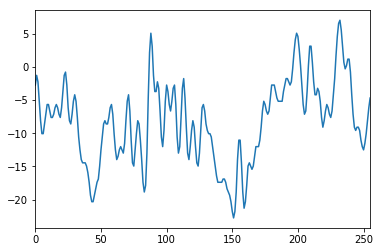

In [11]:
# Extract the time series
def extract_random_data_series(folder):
    selected_subfolder = \
        random.choice([os.path.join(folder, x) for x in os.listdir(folder) if os.path.isdir(os.path.join(folder, x))])
    print('Selected subfolder: %s' % (selected_subfolder))
    selected_file = \
        random.choice([os.path.join(selected_subfolder, x) for x in os.listdir(selected_subfolder) if 
                       os.path.isfile(os.path.join(selected_subfolder, x)) and not x.endswith(".gz")])
    df = pd.read_table(selected_file, skiprows=5, names=['chan', 'ind', 'val'], delim_whitespace=True, usecols=range(1,4))
    df = df.loc[df['chan'] == 'FP1']
    return df['val']

random_ts = extract_random_data_series(r'./eeg_full')
random_ts.plot();
random_ts

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


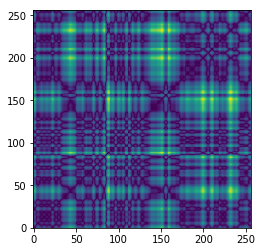

In [61]:
rp = RecurrencePlot(random_ts.values, threshold=0.1)
matrix = rp.distance_matrix([[30],[30]], "euclidean");
plt.ylim(0, 256)
plt.imshow(matrix)
plt.show()

In [81]:
def recurrence_rate(rp):
    N = rp.N

    if not rp.sparse_rqa:
        R = rp.recurrence_matrix()
        RR = R.sum() / float(N ** 2)
    elif rp.sparse_rqa and rp.metric == "supremum":
        RR = (rp.vertline_dist() * np.arange(N)).sum() / \
            float(N ** 2)

    return RR

In [84]:
# Pass time series as an array (ts.values)
def extract_features_from_time_series(ts):
    feats = {
        "RR": None, # Recurrance Rate
        "DET": None, # Determinism
        "L": None, # Average Diagonal Line Length
        "LAM": None, # Laminarity
        "LLE": None, # Largest Lyapunov Exponent
        "CD": None, # Correlation Dimension
        "SamEn": None, # Sample Entropy
        "H": None, # Hurst Exponent
        "DFA": None, # Detrended Fluctuation Analysis
    }
    
    rp = RecurrencePlot(ts, threshold=0.1)
    feats['RR'] = recurrence_rate(rp)
    feats['DET'] = rp.determinism()
    feats['L'] = rp.average_diaglength()
    feats['LAM'] = rp.laminarity()
    feats['LLE'] = max(nolds.lyap_e(ts))
    feats['CD'] = nolds.corr_dim(ts, 10) # TODO: Find optimal embeddind dimension (second param)
    feats['SamEn'] = nolds.sampen(ts)
    feats['H'] = nolds.hurst_rs(ts)
    feats['DFA'] = nolds.dfa(ts)
    
    return feats

feats = extract_features_from_time_series(random_ts.values);

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


{'CD': 0.09178702150094525,
 'DET': 0.13687150837988826,
 'DFA': 1.412841782509581,
 'H': 0.7013918312901257,
 'L': 2.0851063829787235,
 'LAM': 0.1938352104327208,
 'LLE': 0.13869615,
 'RR': 0.0257568359375,
 'SamEn': 0.8638769891901149}

In [111]:
# A helper function
def merge_two_dicts(a, b):
    c = a.copy()
    c.update(b)
    return c

def add_data_from_folder(foldername):
    for item in os.listdir(foldername):
        item = os.path.join(foldername, item)
        if os.path.isdir(item):
            print('Going down folder %s' % item)        
            add_data_from_folder(item)
        elif item.endswith('.gz'):
            print('Skipping zipped file %s' % item)
        elif os.path.isfile(item):
            no_ext_name = os.path.splitext(os.path.splitext(item)[0])[0]
            subject = no_ext_name[-3:]
            df = pd.read_table(item, skiprows=5, names=['chan', 'ind', 'val'], \
                                   delim_whitespace=True, usecols=range(1,4))
            for key, group in df.groupby('chan'):
                f = extract_features_from_time_series(group['val'].values)
                d = {
                    'subject': subject,
                    'channel': key,
                    'label': item[3]
                }
                data = merge_two_dicts(f, d)
                cols = ['subject', 'channel', 'RR', 'DET', 'L', 'LAM', 'LLE', 'CD', 'SamEn', 'H', 'DFA', 'label']
                new_row = pd.DataFrame(data, columns=cols)
                df_global = df_global.append(new_row)
        else:
            raise Exception("Unexpected file %s, this should not happen" % item)
            
    
# cols = ['subject', 'channel', 'RR', 'DET', 'L', 'LAM', 'LLE', 'CD', 'SamEn', 'H', 'DFA', 'label']
# df_global = pd.DataFrame(columns=cols)

# add_data_from_folder('eeg_full')